## Polygon Pipeline Example 

In [1]:
import datetime
import polars as pl
from spectral.data import polygon as pg

pl.Config.set_tbl_rows(n=10)
pl.Config.set_tbl_rows(n=20)

EQUITIES = ['AAPL', 'IBM', 'AMZN', 'MSFT']
BENCHMARK = ['I:NDX']

#### Get Daily Bar Data from Polygon

In [2]:
df = pg.get_aggregate_bars( 
    tickers=EQUITIES + BENCHMARK,
    multiplier=1,
    timespan='day',
    from_=datetime.date(2024, 1, 1),
    to=datetime.date(2025, 10, 13)
)

#### Returns

In [3]:
# Compute returns
returns_df = df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('close').quant.returns(periods=1, over='ticker')
])

# Collect to eager DataFrame and pivot
_returns_df = (
    returns_df.collect()
    .pivot(
        index='timestamp',
        on='ticker',
        values='return'
    )
    .sort('timestamp')
)

# Plot
_returns_df.to_pandas().set_index('timestamp').add(1).cumprod().sub(1).bokeh.plot();

/Users/danieltrivino/Desktop/github/spectral/.venv/lib/python3.12/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


#### Rolling Total Vol

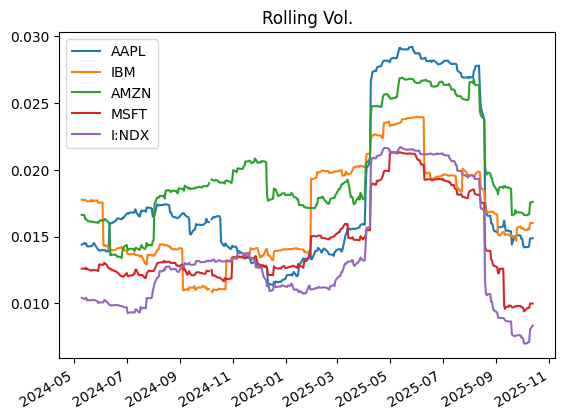

In [4]:
# Compute rolling volatility
vol_df = returns_df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('return').quant.rolling_vol(over='ticker', window_size=90, min_samples=90)
])

# Collect to eager DataFrame and pivot
_vol_df = (
    vol_df.collect()
    .pivot(
        index='timestamp',
        on='ticker',
        values='rolling_vol'
    )
    .sort('timestamp')
)

# Plot
_vol_df.to_pandas().set_index('timestamp').plot(title='Rolling Vol.', xlabel='');

#### Rolling Betas

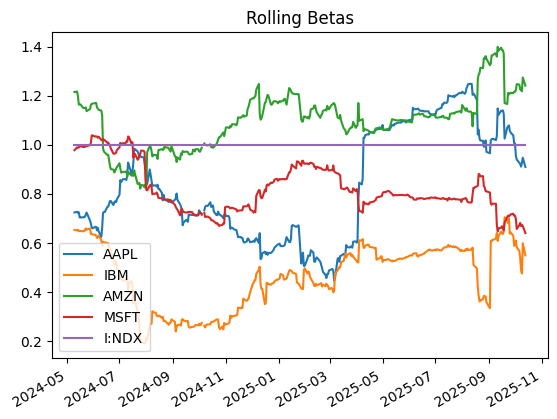

In [5]:
# Separate and merge benchmark returns
benchmark_returns_df = (
    returns_df.filter(pl.col('ticker') == BENCHMARK[0])
    .select(['timestamp', 'return'])
    .rename({'return': 'benchmark_return'})
)
returns_join_df = returns_df.join(other=benchmark_returns_df, on='timestamp', how='inner')

# Compute rolling beta
betas_df = returns_join_df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('return'),
    pl.col('benchmark_return'),
    pl.col('return').quant.rolling_beta(pl.col('benchmark_return'), window_size=90, over='ticker')
])

# Collect to eager DataFrame and pivot
_betas_df = (
    betas_df.collect()
    .pivot(
        index='timestamp',
        on='ticker',
        values='rolling_beta'
    )
    .sort('timestamp')
)

# Plot
_betas_df.to_pandas().set_index(keys='timestamp').plot(title='Rolling Betas', xlabel='');

#### Idiosyncratic Returns

In [ ]:
# Compute idiosyncratic returns
idio_returns_df = betas_df.select(
    pl.col('timestamp'),
    pl.col('ticker'),
    (pl.col('return') - pl.col('rolling_beta') * pl.col('benchmark_return')).alias('idio_return')
)

# Collect to eager DataFrame and pivot
_idio_returns_df = (
    idio_returns_df.collect()
    .pivot(
        index='timestamp',
        on='ticker',
        values='idio_return'
    )
    .sort('timestamp')
)

# Plot
_idio_returns_df.to_pandas().set_index('timestamp').add(1).cumprod().sub(1).plot(title='Idio Returns', xlabel='');

#### Rolling Idio Vol

In [ ]:
# Compute rolling idio volatility
idio_vol_df = idio_returns_df.select([
    pl.col('timestamp'),
    pl.col('ticker'),
    pl.col('idio_return').quant.rolling_vol(over='ticker', window_size=90, min_samples=90).alias('rolling_idio_vol')
])

# Collect to eager DataFrame and pivot
_idio_vol_df = (
    idio_vol_df.collect()
    .pivot(
        index='timestamp',
        on='ticker',
        values='rolling_idio_vol'
    )
    .sort('timestamp')
)

# Plot
_idio_vol_df.to_pandas().set_index('timestamp').plot(title='Rolling Idio. Vol.', xlabel='');

In [ ]:
ax = _idio_vol_df.to_pandas().set_index('timestamp').plot(title='Rolling Total and Idio. Vol.', xlabel='', colormap='tab10')
_vol_df.to_pandas().set_index('timestamp').plot(ax=ax, xlabel='', colormap='tab10', legend=False);

In [11]:
from spectral.portfolio import *

In [12]:
portfolio = Portfolio(
    df=returns_df.collect().join(other=betas_df.collect(), on=['timestamp', 'ticker']), 
    portfolio={'AAPL': 0.25, 'IBM': 0.25, 'AMZN': 0.25, 'MSFT': 0.25}, 
    benchmark=BENCHMARK[0]
)

In [13]:
portfolio.compute_returns()

ColumnNotFoundError: unable to find column "beta"; valid columns: ["timestamp", "ticker", "return", "return_right", "benchmark_return", "rolling_beta", "weight", "benchmark_return_right"]